# Forecast of Minneapolis-St. Paul Temperature
This notebook is written to build a model for predicting minnesota weather with a focus on minumum temperature. The data source can be found on Minnesota Department of Natural Resources website: https://www.dnr.state.mn.us/climate/historical/daily-data.html?sid=mspthr&sname=Minneapolis/St%20Paul%20Threaded%20Record&sdate=2010-01-01&edate=por.
A csv data file will be downloaded. It is dataset of daily minimum temperatures, daily maxium temperatures and other parameters in twin cities of Minnesota measured from 2010 to 2020 (October). Here I will use the daily minimum temperatureto to build a prediction model.
TensorFlow will be used to build a neural network for training of the time series data and make a forecast, with combination of convolutional neural network, recurrent neural network and deep neural network. Mean absolute error is used to evaluate the model.
## 1. Import, review and preprocess the data



In [1]:
import tensorflow as tf
print(tf.__version__)

2.1.0


In [2]:
# Import Numpy, Matplotlib, seaborn and build a function for plotting the time series
import numpy as np
# ! python -m pip install -U matplotlib
import matplotlib.pyplot as plt
# ! python -m pip install -U seaborn
import seaborn as sns
sns.set()
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Min Temperature in F")
    plt.grid(True)

In [3]:
# Import the data
import csv
time_step = []
temps = []
with open('MSP weather 2010-2020.csv') as csvfile:
  reader = csv.reader(csvfile, delimiter=',')
  next(reader)
  step=0
  for row in reader:
    temps.append(float(row[2]))
    time_step.append(step)
    step = step + 1

series = np.array(temps)
time = np.array(time_step)

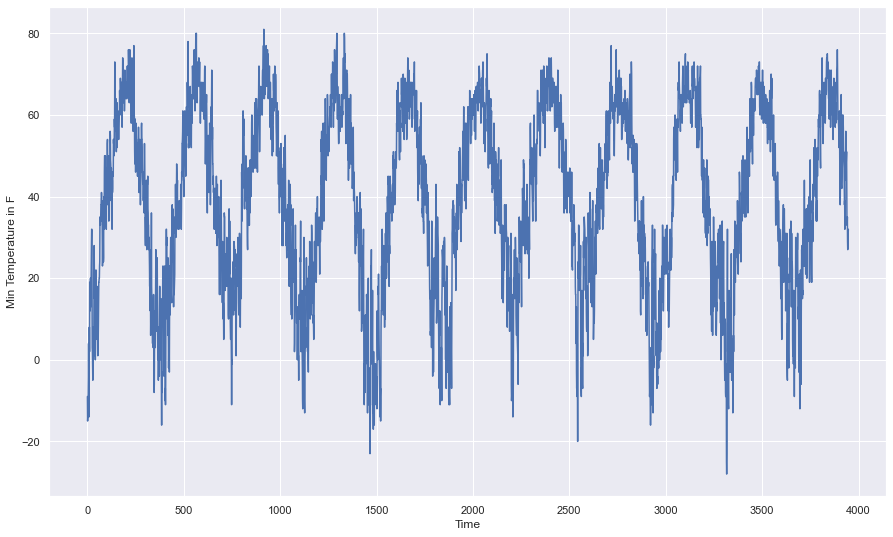

In [4]:
# Plot the time series
plt.figure(figsize=(15, 9))
plot_series(time, series)

In [5]:
# Split the time series into training set and validation set
# As a year contains 365 days, 3000 would include enough number of seasons for training purpose
split_time = 3000
time_train = time[:split_time]
series_train = series[:split_time]
time_valid = time[split_time:]
series_valid = series[split_time:]

In [6]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

In [7]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

## 2. Build and optimize the model

In [8]:
# Try to use Stochastic Gradient Descent to find an optimized learning rate
# Use Mean Absolute Error as the metrics
tf.keras.backend.clear_session()
tf.random.set_seed(10)
np.random.seed(10)
window_size = 30
batch_size = 200
shuffle_buffer_size = 1000
train_set = windowed_dataset(series_train, window_size, batch_size, shuffle_buffer_size)
print(train_set)
print(series_train.shape)

model = tf.keras.models.Sequential([
    # 1st layer: convolutional newral network
    tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
      # add two layers of long term short memory
    tf.keras.layers.LSTM(64, return_sequences=True),
    tf.keras.layers.LSTM(64, return_sequences=True),
    # add three layers of neural network
    tf.keras.layers.Dense(30, activation="relu"),  
    tf.keras.layers.Dense(10, activation="relu"),
    tf.keras.layers.Dense(1),
    # as maximum of the tempertaure is in about 80, so use 80 as the scale for better traning purpose
    tf.keras.layers.Lambda(lambda x: x * 80)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

<PrefetchDataset shapes: ((None, None, 1), (None, None, 1)), types: (tf.float64, tf.float64)>
(3000,)
Epoch 1/100
15/15 [==============================] - 5s 331ms/step - loss: 89.9648 - mae: 90.4890
Epoch 2/100
15/15 [==============================] - 1s 97ms/step - loss: 89.3769 - mae: 89.8920
Epoch 3/100
15/15 [==============================] - 1s 87ms/step - loss: 88.5167 - mae: 89.0079
Epoch 4/100
15/15 [==============================] - 1s 85ms/step - loss: 87.3686 - mae: 87.8508
Epoch 5/100
15/15 [==============================] - 1s 90ms/step - loss: 85.6783 - mae: 86.2272
Epoch 6/100
15/15 [==============================] - 1s 87ms/step - loss: 82.7197 - mae: 83.2420
Epoch 7/100
15/15 [==============================] - 1s 87ms/step - loss: 76.3483 - mae: 76.8797
Epoch 8/100
15/15 [==============================] - 1s 88ms/step - loss: 73.7547 - mae: 74.2803
Epoch 9/100
15/15 [==============================] - 1s 86ms/step - loss: 72.6960 - mae: 73.2191
Epoch 10/100
15/15 [====

15/15 [==============================] - 1s 84ms/step - loss: 5.5277 - mae: 6.0126
Epoch 84/100
15/15 [==============================] - 1s 85ms/step - loss: 5.6966 - mae: 6.1840
Epoch 85/100
15/15 [==============================] - 1s 83ms/step - loss: 5.6393 - mae: 6.1277
Epoch 86/100
15/15 [==============================] - 1s 83ms/step - loss: 6.1720 - mae: 6.6612
Epoch 87/100
15/15 [==============================] - 1s 86ms/step - loss: 5.8913 - mae: 6.3856
Epoch 88/100
15/15 [==============================] - 1s 83ms/step - loss: 6.4917 - mae: 6.9647
Epoch 89/100
15/15 [==============================] - 1s 84ms/step - loss: 7.9825 - mae: 8.4488
Epoch 90/100
15/15 [==============================] - 1s 85ms/step - loss: 8.6724 - mae: 9.1827
Epoch 91/100
15/15 [==============================] - 1s 83ms/step - loss: 7.5844 - mae: 8.0919
Epoch 92/100
15/15 [==============================] - 1s 85ms/step - loss: 6.3725 - mae: 6.8688
Epoch 93/100
15/15 [==============================] -

Text(0, 0.5, 'Loss')

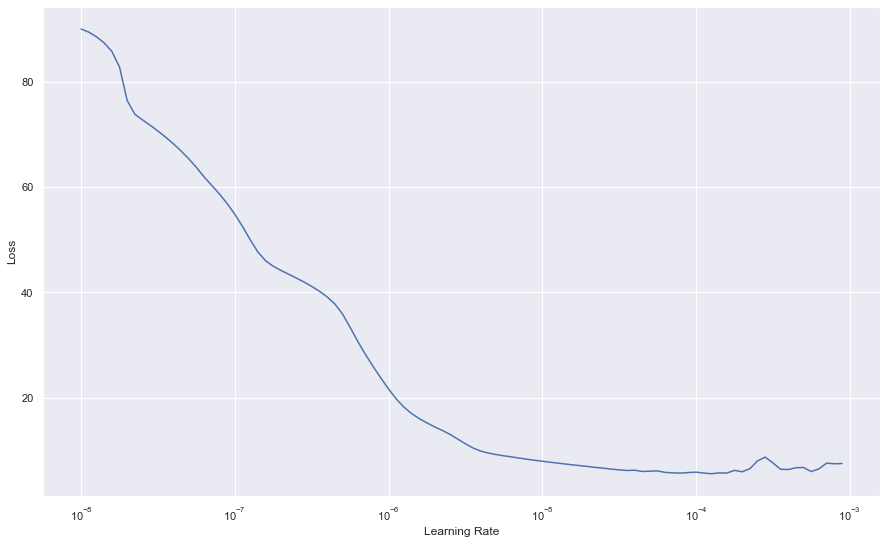

In [9]:
plt.figure(figsize=(15, 9))
plt.semilogx(history.history["lr"], history.history["loss"])
plt.xlabel('Learning Rate')
plt.ylabel("Loss")

In [10]:
# Then the learnig rate is fixed at 1e-4 by which the loss is optimized
tf.keras.backend.clear_session()
tf.random.set_seed(10)
np.random.seed(10)
train_set = windowed_dataset(series_train, window_size=60, batch_size=100, shuffle_buffer=shuffle_buffer_size)
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=60, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
    tf.keras.layers.LSTM(64, return_sequences=True),
    tf.keras.layers.LSTM(64, return_sequences=True),
    tf.keras.layers.Dense(30, activation="relu"),
    tf.keras.layers.Dense(10, activation="relu"),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Lambda(lambda x: x * 80)
])


optimizer = tf.keras.optimizers.SGD(lr=1e-4, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set,epochs=500)

Epoch 1/500
30/30 [==============================] - 6s 202ms/step - loss: 19.3763 - mae: 20.0925
Epoch 2/500
30/30 [==============================] - 3s 113ms/step - loss: 9.2007 - mae: 9.7366
Epoch 3/500
30/30 [==============================] - 3s 110ms/step - loss: 6.9474 - mae: 7.4533
Epoch 4/500
30/30 [==============================] - 3s 111ms/step - loss: 6.7881 - mae: 7.2936
Epoch 5/500
30/30 [==============================] - 3s 110ms/step - loss: 5.7978 - mae: 6.2828
Epoch 6/500
30/30 [==============================] - 3s 110ms/step - loss: 5.9946 - mae: 6.4677
Epoch 7/500
30/30 [==============================] - 3s 110ms/step - loss: 5.5575 - mae: 6.0461
Epoch 8/500
30/30 [==============================] - 3s 109ms/step - loss: 5.5252 - mae: 6.0060
Epoch 9/500
30/30 [==============================] - 3s 108ms/step - loss: 5.4688 - mae: 5.9502
Epoch 10/500
30/30 [==============================] - 3s 116ms/step - loss: 5.2427 - mae: 5.7293
Epoch 11/500
30/30 [=================

30/30 [==============================] - 3s 108ms/step - loss: 4.1159 - mae: 4.5892
Epoch 86/500
30/30 [==============================] - 3s 109ms/step - loss: 4.1627 - mae: 4.6433
Epoch 87/500
30/30 [==============================] - 3s 109ms/step - loss: 4.1138 - mae: 4.5873
Epoch 88/500
30/30 [==============================] - 3s 109ms/step - loss: 4.2065 - mae: 4.6820
Epoch 89/500
30/30 [==============================] - 3s 109ms/step - loss: 4.2167 - mae: 4.6896
Epoch 90/500
30/30 [==============================] - 3s 109ms/step - loss: 4.1919 - mae: 4.6752
Epoch 91/500
30/30 [==============================] - 3s 108ms/step - loss: 4.1474 - mae: 4.6229
Epoch 92/500
30/30 [==============================] - 3s 109ms/step - loss: 4.2694 - mae: 4.7429
Epoch 93/500
30/30 [==============================] - 3s 107ms/step - loss: 4.1451 - mae: 4.6230
Epoch 94/500
30/30 [==============================] - 3s 109ms/step - loss: 4.1512 - mae: 4.6311
Epoch 95/500
30/30 [=======================

30/30 [==============================] - 3s 115ms/step - loss: 3.9360 - mae: 4.4073
Epoch 169/500
30/30 [==============================] - 3s 111ms/step - loss: 4.0666 - mae: 4.5465
Epoch 170/500
30/30 [==============================] - 3s 107ms/step - loss: 3.9724 - mae: 4.4436
Epoch 171/500
30/30 [==============================] - 3s 108ms/step - loss: 3.9345 - mae: 4.4073
Epoch 172/500
30/30 [==============================] - 3s 107ms/step - loss: 3.9517 - mae: 4.4225
Epoch 173/500
30/30 [==============================] - 3s 108ms/step - loss: 3.9702 - mae: 4.4400
Epoch 174/500
30/30 [==============================] - 3s 110ms/step - loss: 3.9353 - mae: 4.4045
Epoch 175/500
30/30 [==============================] - 3s 108ms/step - loss: 3.9480 - mae: 4.4210
Epoch 176/500
30/30 [==============================] - 3s 109ms/step - loss: 3.9769 - mae: 4.4527
Epoch 177/500
30/30 [==============================] - 3s 109ms/step - loss: 3.9322 - mae: 4.4046
Epoch 178/500
30/30 [=============

30/30 [==============================] - 3s 107ms/step - loss: 3.8311 - mae: 4.3018
Epoch 252/500
30/30 [==============================] - 3s 108ms/step - loss: 3.9058 - mae: 4.3774
Epoch 253/500
30/30 [==============================] - 3s 108ms/step - loss: 3.8269 - mae: 4.2943
Epoch 254/500
30/30 [==============================] - 3s 108ms/step - loss: 3.8515 - mae: 4.3256
Epoch 255/500
30/30 [==============================] - 3s 109ms/step - loss: 3.7898 - mae: 4.2601
Epoch 256/500
30/30 [==============================] - 3s 108ms/step - loss: 3.8412 - mae: 4.3129
Epoch 257/500
30/30 [==============================] - 3s 109ms/step - loss: 3.9027 - mae: 4.3735
Epoch 258/500
30/30 [==============================] - 3s 108ms/step - loss: 3.8319 - mae: 4.3043
Epoch 259/500
30/30 [==============================] - 3s 108ms/step - loss: 3.7860 - mae: 4.2562
Epoch 260/500
30/30 [==============================] - 3s 108ms/step - loss: 3.8004 - mae: 4.2737
Epoch 261/500
30/30 [=============

30/30 [==============================] - 3s 113ms/step - loss: 3.6803 - mae: 4.1505
Epoch 335/500
30/30 [==============================] - 3s 107ms/step - loss: 3.7383 - mae: 4.2119
Epoch 336/500
30/30 [==============================] - 3s 108ms/step - loss: 3.6603 - mae: 4.1331
Epoch 337/500
30/30 [==============================] - 3s 107ms/step - loss: 3.6577 - mae: 4.1226
Epoch 338/500
30/30 [==============================] - 3s 107ms/step - loss: 3.7171 - mae: 4.1910
Epoch 339/500
30/30 [==============================] - 3s 108ms/step - loss: 3.7674 - mae: 4.2383
Epoch 340/500
30/30 [==============================] - 3s 108ms/step - loss: 3.7085 - mae: 4.1713
Epoch 341/500
30/30 [==============================] - 3s 108ms/step - loss: 3.6853 - mae: 4.1543
Epoch 342/500
30/30 [==============================] - 3s 108ms/step - loss: 3.6834 - mae: 4.1528
Epoch 343/500
30/30 [==============================] - 3s 109ms/step - loss: 3.7788 - mae: 4.2436
Epoch 344/500
30/30 [=============

30/30 [==============================] - 3s 109ms/step - loss: 3.5958 - mae: 4.0669
Epoch 418/500
30/30 [==============================] - 3s 108ms/step - loss: 3.6375 - mae: 4.1093
Epoch 419/500
30/30 [==============================] - 3s 108ms/step - loss: 3.5698 - mae: 4.0410
Epoch 420/500
30/30 [==============================] - 3s 109ms/step - loss: 3.5891 - mae: 4.0602
Epoch 421/500
30/30 [==============================] - 3s 107ms/step - loss: 3.5439 - mae: 4.0118
Epoch 422/500
30/30 [==============================] - 3s 107ms/step - loss: 3.6030 - mae: 4.0665
Epoch 423/500
30/30 [==============================] - 3s 108ms/step - loss: 3.5966 - mae: 4.0622
Epoch 424/500
30/30 [==============================] - 3s 108ms/step - loss: 3.5851 - mae: 4.0538
Epoch 425/500
30/30 [==============================] - 3s 111ms/step - loss: 3.5690 - mae: 4.0345
Epoch 426/500
30/30 [==============================] - 3s 111ms/step - loss: 3.6570 - mae: 4.1270
Epoch 427/500
30/30 [=============

30/30 [==============================] - 3s 108ms/step - loss: 3.4834 - mae: 3.9440


## 3. Make the forecast of minimum daily temperature on the validaton data set

In [11]:
# Forecast the minumum daily temperature based on the model
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

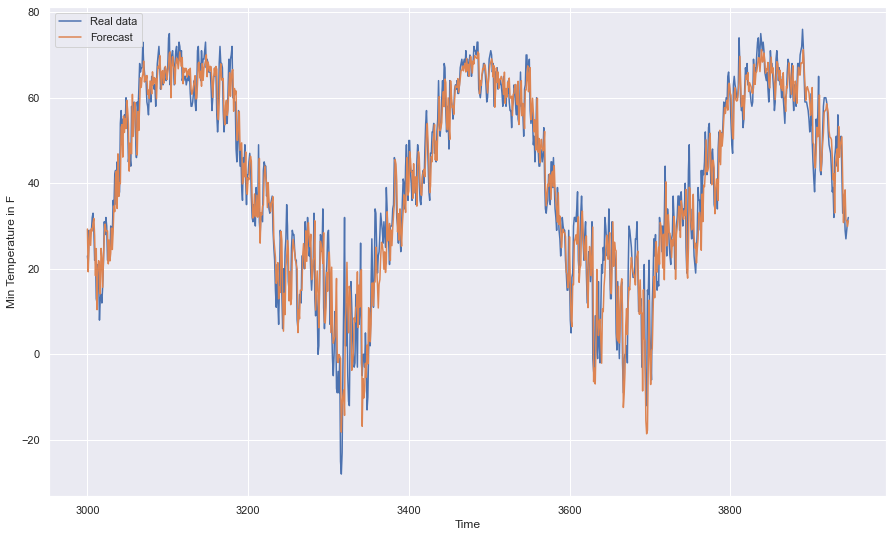

In [12]:
# Print the forecast data
plt.figure(figsize=(15, 9))
plot_series(time_valid, series_valid)
plot_series(time_valid, rnn_forecast)
plt.legend(['Real data', 'Forecast'])

The fitting above looks good, so the mean absolute error is calculated below, which is about 4.87. Also the loss is decreased sharply before 30 epochs and decreased slowly as increasing the number of epochs further even fluctuation has been observed. 

In [13]:
print("Mean Absolute Error for the forecast:", tf.keras.metrics.mean_absolute_error(series_valid, rnn_forecast).numpy())

Mean Absolute Error for the forecast: 4.8743615


<Figure size 432x288 with 0 Axes>

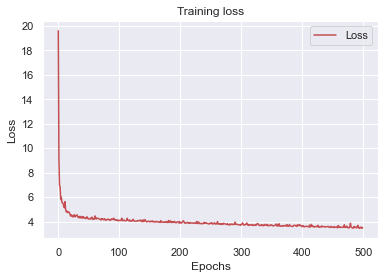

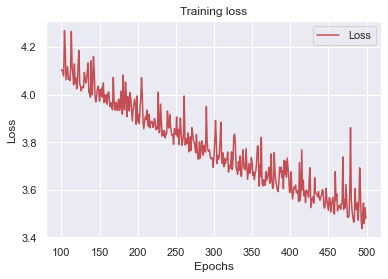

<Figure size 432x288 with 0 Axes>

In [15]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

loss=history.history['loss']

epochs=range(len(loss)) # Get number of epochs


# Plot training and validation loss per epoch
plt.plot(epochs, loss, 'r')
plt.title('Training loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss"])
plt.figure()

#Zoom in and plot training and validation loss per epoch
zoomed_loss = loss[100:]
zoomed_epochs = range(100,500)
plt.plot(zoomed_epochs, zoomed_loss, 'r')
plt.title('Training loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss"])
plt.figure()

# 4. References
1. Coursera Course by deeplearning.ai: Sequences, Time Series and Prediction
https://www.coursera.org/learn/tensorflow-sequences-time-series-and-prediction/home/welcome
2. Daily weather report of Minneapolis/St Paul Threaded Record:
 https://www.dnr.state.mn.us/climate/historical/daily-data.html?sid=mspthr&sname=Minneapolis/St%20Paul%20Threaded%20Record&sdate=2010-01-01&edate=por.